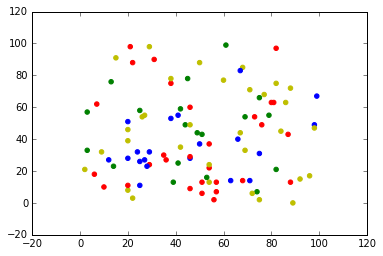

Before clustering...


In [1]:
from pyspark import SparkContext
import numpy as np
import matplotlib.pyplot as plt

def plot_cluster(data):
    x = data[:, 2]
    y = data[:, 3]
    l = data[:, 1]
    c = list("rgby")
    color = map(lambda x: c[x], l)
    plt.scatter(x, y, color=color)
    plt.show()

sc = SparkContext('local', 'pyspark')
rawdata = sc.textFile('file').map(lambda x: x.split('\t')).map(lambda x: map(float, x))
# [data_id, ctrd_id, x1, x2]

# Plot unclustered
plot_cluster(np.array(rawdata.collect(), dtype=int))
print "Before clustering..."

N = 100    # Number of data ponits    
D = 2      # Dimensions
MAX = 10   # Max number of iterations

Iteration = 0


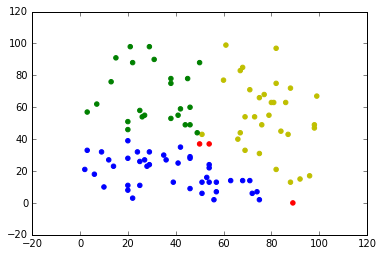

Num of centroid assignment updates = 68
Iteration = 1


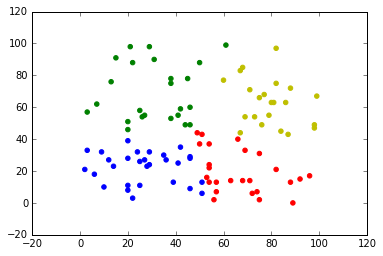

Num of centroid assignment updates = 23
Iteration = 2


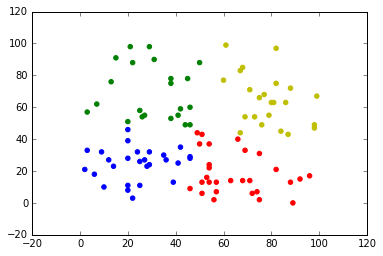

Num of centroid assignment updates = 5
Iteration = 3


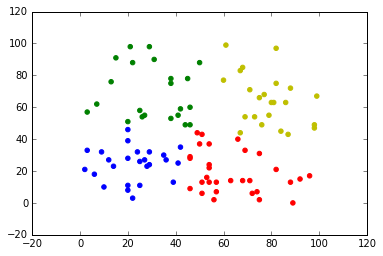

Num of centroid assignment updates = 2
Iteration = 4


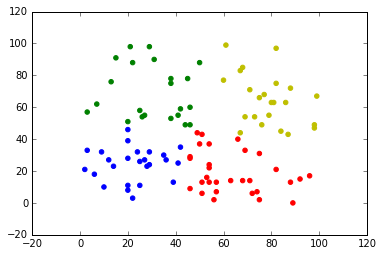

Num of centroid assignment updates = 0
No updates necessary...
Finished!


In [2]:
for c in range(MAX):
    print 'Iteration = %d' % c
    data = rawdata.collect()
    data = zip(*data)
    assnmt1 = dict(zip(data[0], data[1]))

    ## Update centroid
    dataCentroidKey = rawdata.map(lambda x: [x[1], x + [1.0]])
    # [ctrd_id, [data_id, ctrd_id, x1, x2, 1]]

    centroid = dataCentroidKey.reduceByKey(lambda x, y: np.array(x) + np.array(y))
    # [ctrd_id, [~, ~, sum_x1, sum_x2, N]]

    centroid = centroid.mapValues(lambda x: list(x[2 : 2 + D] / x[2 + D]))
    # [ctrd_id, [sum_x1/N, sum_x2/N]]

    ## Assign data
    dataIdKey = rawdata.map(lambda x: [x[0], x])
    # [data_id, [data_id, ctrd_id, x1, x2]]

    centroid = centroid.map(lambda x: [x[0]] + x[1])
    # [ctrd_id, sum_x1/N, sum_x2/N]

    cartesian = centroid.flatMap(lambda x: [[float(i), x] for i in range(N)])
    # [i, [ctrd_id, mean_x1, mean_x2]]	i in range(N)
    
    grouped = dataIdKey.cogroup(cartesian)
    # (data_id,
    #    (
    #       iterable([data_id, ctrd_id, x1, x2]),
    #       iterable([ctrd_id, mean_x1, mean_x2]...)
    #)
    # )

    grouped = grouped.mapValues(lambda x: [list(x[0])[0], list(x[1])])
    # (data_id,
    #   [
    #       [data_id, ctrd_id, x1, x2],
    #       [[ctrd_id, mean_x1, mean_x2]...]
    #   ]
    # )

    grouped = grouped.mapValues(lambda x: [[x[1][i][0], np.linalg.norm(np.array(x[0][2:]) - np.array(x[1][i][1:]))] + x[0][2:] for i in range(len(x[1]))])
    # (data_id, [[ctrd_id, dist, x1, x2]...])

    grouped = grouped.mapValues(lambda x: min(x, key = lambda x: x[1]))
    # (data_id, [ctrd_id, mindist, x1, x2])

    rawdata = grouped.map(lambda x: [x[0], x[1][0]] + x[1][2:])
    # [data_id, ctrd_id, x1, x2]

    plot_cluster(np.array(rawdata.collect(), dtype=int))
    
    data = rawdata.collect()
    data = zip(*data)
    assnmt2 = dict(zip(data[0], data[1]))

    changed = 0
    for k in assnmt1.keys():
        if assnmt1[k] != assnmt2[k]:
            changed += 1

    print 'Num of centroid assignment updates = %d' % changed
    if changed == 0:
        print 'No updates necessary...\nFinished!'
        break